# XGBoost running with only VVR_1 and VVR_2

Import libraries. 

In [1]:
# Import necessary libraries
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, confusion_matrix
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 
from collections import Counter

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_train_12.csv')
y_train_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_train_12.csv')
X_test_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_test_12.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_test.csv')

X_train_12 = X_train_12.drop(columns='Unnamed: 0', axis=1)
y_train_12 = y_train_12.drop(columns='Unnamed: 0', axis=1)
X_test_12 = X_test_12.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

print(X_train_12.columns)
print(X_test_12.columns)


# Convert the DataFrame to a 1-dimensional NumPy array
y_train_12 = y_train_12.values.ravel()
y_test = y_test.values.ravel()


Index(['Sum_1', 'Sum_2'], dtype='object')
Index(['Sum_1', 'Sum_2'], dtype='object')


# Model with inner and outer split

New. 

In [4]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2)
rfe = RFE(estimator=DecisionTreeClassifier())
model = XGBClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

# param_grid = {
#     'm__learning_rate': [0.1, 0.01],  # Learning rate
#     'm__n_estimators': [50, 100, 200],  # Number of trees
#     'm__max_depth': [3, 5, 8],  # Maximum depth of a tree
#     'm__min_child_weight': [1, 5],  # Minimum sum of instance weight needed in a child
#     's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE
# }

param_grid = {'m__learning_rate': [0.1], 
              'm__max_depth': [3], 
              'm__min_child_weight': [1], 
              'm__n_estimators': [100], 
            #   's__n_features_to_select': [10]
              }

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_12, y_train_12, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_12.shape)
print(y_train_12.shape)

# Fit model to training data to get best parameters
model.fit(X_train_12, y_train_12)

# Print best parameters
print(model.best_params_)

# Print the features that were selected with RFE

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test_12)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test_12)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))


The mean score using nested cross-validation is: 0.636 ± 0.025
(77, 2)
(77,)
{'m__learning_rate': 0.1, 'm__max_depth': 3, 'm__min_child_weight': 1, 'm__n_estimators': 100}
(34,)
(34,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.75      0.27      0.40        11

    accuracy                           0.74        34
   macro avg       0.74      0.61      0.62        34
weighted avg       0.74      0.74      0.69        34

[[22  1]
 [ 8  3]]
AUC-PR: 0.599


Old. 

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 

In [5]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2)
rfe = RFE(estimator=DecisionTreeClassifier())
model = XGBClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

# param_grid = {
#     'm__learning_rate': [0.1, 0.01],  # Learning rate
#     'm__n_estimators': [50, 100, 200],  # Number of trees
#     'm__max_depth': [3, 5, 8],  # Maximum depth of a tree
#     'm__min_child_weight': [1, 5],  # Minimum sum of instance weight needed in a child
#     's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE
# }

param_grid = {'m__learning_rate': [0.1], 
              'm__max_depth': [3], 
              'm__min_child_weight': [1], 
              'm__n_estimators': [100], 
            #   's__n_features_to_select': [10]
              }

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_12, y_train_12, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_12.shape)
print(y_train_12.shape)

# Fit model to training data to get best parameters
model.fit(X_train_12, y_train_12)

# Print best parameters
print(model.best_params_)

# Print the features that were selected with RFE

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test_12)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test_12)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))


The mean score using nested cross-validation is: 0.847 ± 0.071
(72, 2)
(72,)
{'m__learning_rate': 0.1, 'm__max_depth': 3, 'm__min_child_weight': 1, 'm__n_estimators': 100, 's__n_features_to_select': 10}
(32,)
(32,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.67      0.57      0.62         7

    accuracy                           0.84        32
   macro avg       0.78      0.75      0.76        32
weighted avg       0.84      0.84      0.84        32

[[23  2]
 [ 3  4]]
AUC-PR: 0.634


# Confusion matrix 

New. 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_6511/3791479120.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


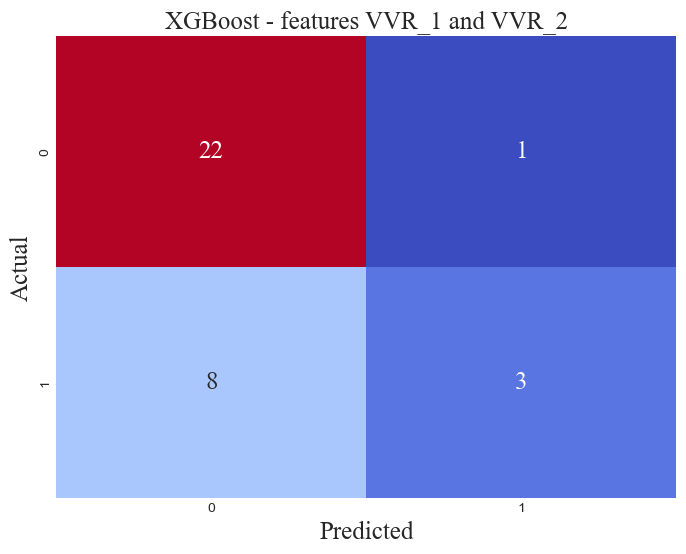

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('XGBoost - features VVR_1 and VVR_2', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()

Old. 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('XGBoost - features VVR_1 and VVR_2', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()